In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos, ProgressionVisualizer
from IPython.display import Image, display
from collections import defaultdict

# Configure Test

Testing an individual board

In [6]:
# From the dataset - ground truth
{"fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1","responseMoves":["Rxf7"],"saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],"solution":["Rxf7","Qxc7"]}

{'fen': '3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1',
 'responseMoves': ['Rxf7'],
 'saliencyGroundTruth': ['f1', 'h2', 'c3', 'e1', 'b3', 'h7', 'g3', 'g7'],
 'solution': ['Rxf7', 'Qxc7']}

In [7]:
FEN = "r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1"
action = None
DISCOUNT_FACTOR = 0.9
DEPTH = 3
RUNTIME=2.0

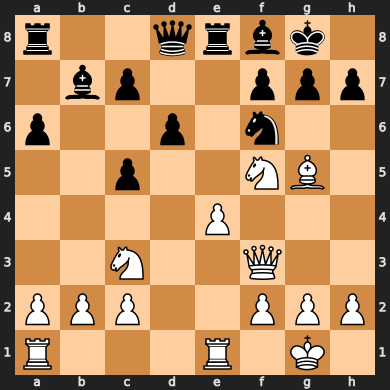

In [8]:
board = chess.Board(FEN)
board_visualization = BoardVisualization(board)
board_visualization.only_board()

# Algorithm Sanity Test

## Algorithm Definition

In [9]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm(fen, discount_factor, depth, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
                optimal_move_q = sarfa_compute_result.optimal_move_q_val
            
            # update original board position saliency for the result
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))

            # make a copy that is used for visualizing timestamp saliencing
            saliency_results_timestep[perturbed_position_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        moves_taken.append(optimal_move_obj)
        board.push(optimal_move_obj)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

## 2 Seconds

In [10]:
saliency_results_per_step = []
moves_taken = []

saliency_results, saliency_results_per_step, moves_taken = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=2.0)

curr step: 0
curr step: 1
curr step: 2


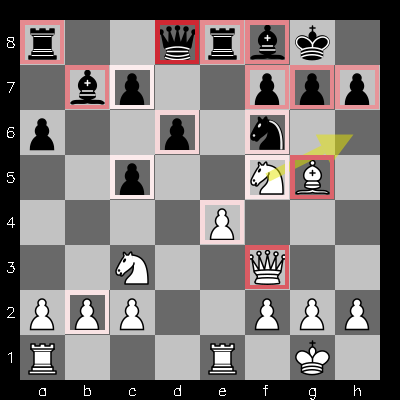

In [11]:
# Final resulting saliency map
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

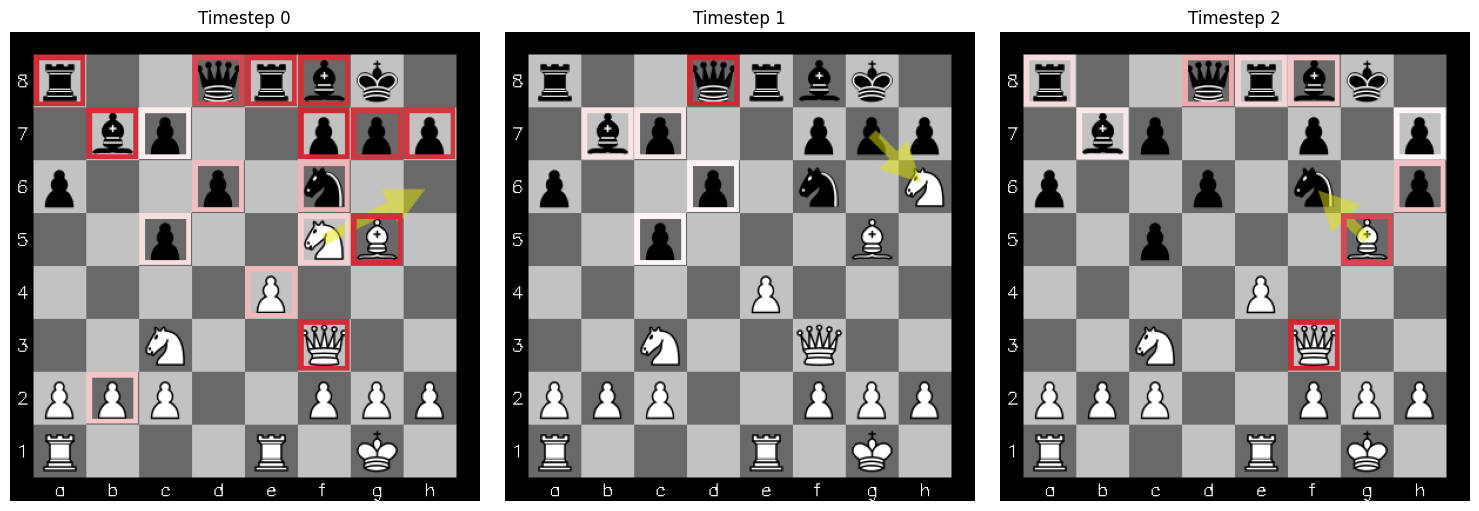

In [17]:
# saliency per timestep
progression_visualizer = ProgressionVisualizer(saliency_results_per_step, moves_taken)
fig = progression_visualizer.show()
fig.show()

## 4 Seconds

In [18]:
saliency_results, saliency_results_per_step, moves_taken = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=4.0)

curr step: 0
curr step: 1
curr step: 2


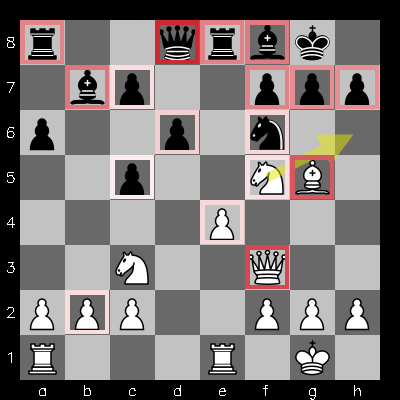

In [19]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

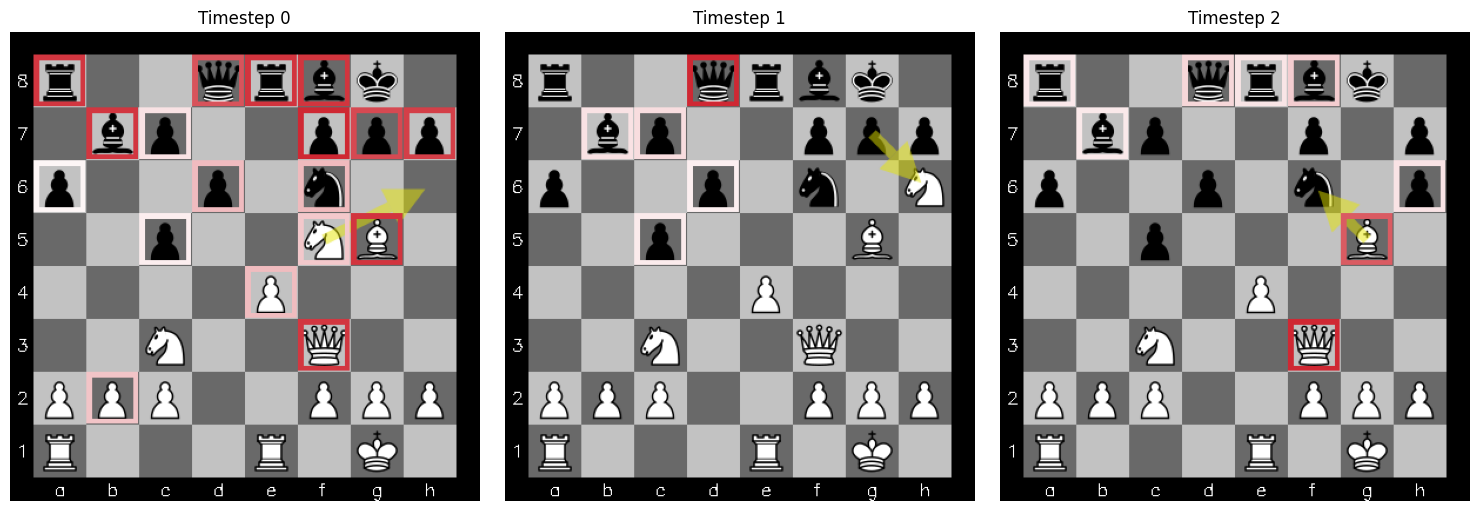

In [21]:
# saliency per timestep
progression_visualizer = ProgressionVisualizer(saliency_results_per_step, moves_taken)
fig = progression_visualizer.show()
fig.show()

# Benchmark

In [28]:
from chess_dataset import SarfaBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Settings

Settings for the benchmark that is going to be run. 

In [29]:
# settings
DISCOUNT_FACTOR = 0.9
DEPTH = 3
RUNTIME=2.0

name = f"sarfa_sequential_{int(RUNTIME * 10)}_{int(DISCOUNT_FACTOR * 100)}_{DEPTH}"
name

'sarfa_sequential_20_90_3'

In [30]:
# function used by benchmark to produce saliency map given FEN
sequential_benchmark_function = lambda x, _: sequential_saliency_algorithm(x, DISCOUNT_FACTOR, DEPTH, RUNTIME)[0]


## Run

```python

sanity_check=True

```

To run only 5 and see if your code is working

In [31]:
benchmark = SarfaBenchmark.run(sequential_benchmark_function, name=name, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
curr step: 0
curr step: 1
curr step: 2
r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
curr step: 0
curr step: 1


KeyboardInterrupt: 

# Analysis

In [32]:
sarfa_benchmark = SarfaBenchmark.load_results(sequential_benchmark_function, name)

In [33]:
sarfa_benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7143901852504448}

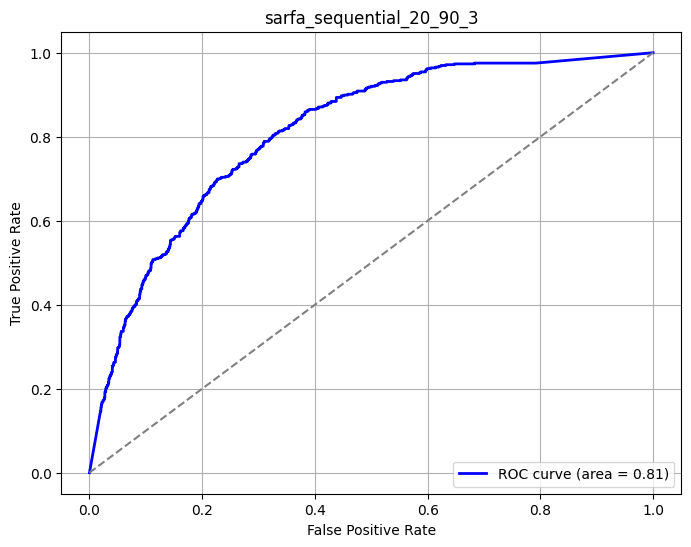

In [34]:
fig = sarfa_benchmark.plot_roc(name=name)
display(fig)

## Show Divergent Move Choices

Goal of this is to show that the Stockfish 15 is choosing different actions than what the expert in the dataset are saying to choose

```json
{
    "fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1",
    "responseMoves":["Rxf7"],
    "saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],
    "solution":["Rxf7","Qxc7"]
}

```

In [35]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
board = chess.Board(FEN)
board_visualizer = BoardVisualization(board.copy())

predicted_saliency, predicted_saliency_timestamps, predicted_moves = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH)


curr step: 0
curr step: 1
curr step: 2


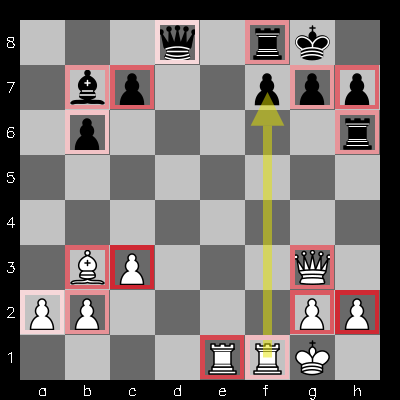

In [36]:
board_visualizer = BoardVisualization(board.copy())

path = board_visualizer.show_heatmap(predicted_saliency, predicted_moves[0])
display(Image(path))

### Moves made by Stockfish

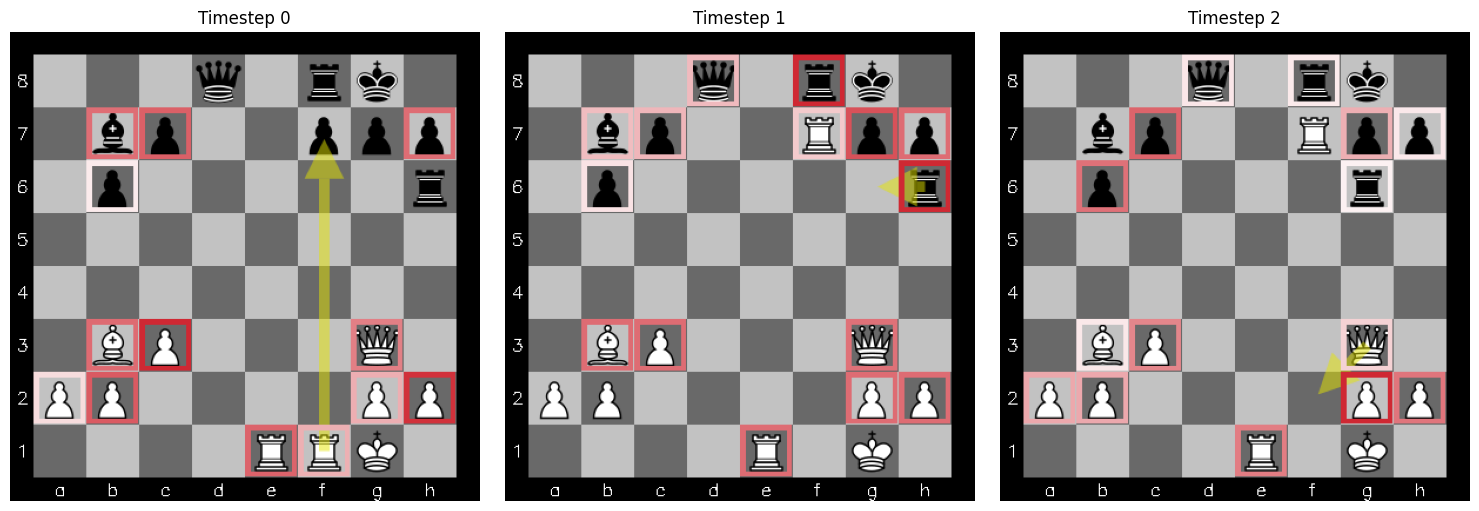

In [37]:
# saliency per timestep
progression_visualizer = ProgressionVisualizer(predicted_saliency_timestamps, predicted_moves)
fig = progression_visualizer.show()
fig.show()

### Moves expert said to take

In [39]:
ground_truth_moves = ["Rxf7","Rxf7", "Qxc7"]
board = chess.Board(FEN)
saliency = {k: 1 for k in ["f1","h2","c3","e1","b3","h7","g3","g7"]}


ground_truth_boards = []
uci_moves = []
for move in ground_truth_moves:
    ground_truth_boards.append((
        saliency,
        board.copy())
    )
    uci = board.push_san(move)
    uci_moves.append(uci)

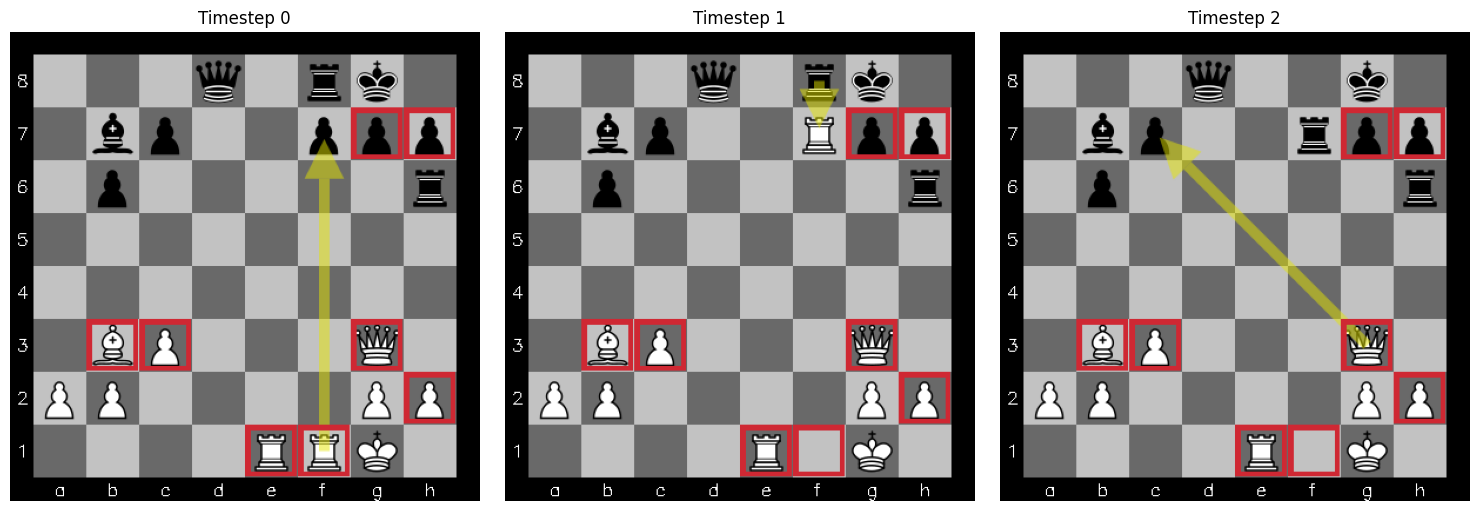

In [40]:
progression_visualizer = ProgressionVisualizer(ground_truth_boards, uci_moves)
fig = progression_visualizer.show()
fig.show()

In [73]:
# Show the final board for ground truth and calculated side by side
from PIL import Image as PILImage

import matplotlib.pyplot as plt
from PIL import Image as PILImage

def show_saliency_comparison(fen, saliencies, names, best_move: chess.Move):
    """
    Displays a comparison of saliency heatmaps in a 1 x n row.
    Takes in a list of saliencies and corresponding names.
    
    Parameters:
    - fen (str): FEN of the current chessboard.
    - saliencies (list): List of saliency data for each heatmap.
    - names (list): List of titles to be used for each subplot.
    - best_move (chess.Move): The best move to be visualized on the board.
    """
    
    # Initialize the board visualizer
    board_visualizer = BoardVisualization(chess.Board(fen))

    # Create a figure with 1 row and n columns (length of the saliencies list)
    fig, axes = plt.subplots(1, len(saliencies), figsize=(12, 6))

    # Ensure axes is iterable even if there's only one subplot
    if len(saliencies) == 1:
        axes = [axes]

    # Loop over each saliency and its corresponding name
    for i, (saliency, name) in enumerate(zip(saliencies, names)):
        board_visualizer.DRAWING_FILE = f"svg_custom/board_{name}"
        path = board_visualizer.show_heatmap(saliency, best_move)
        
        # Load the saliency image
        img = PILImage.open(path)
        
        # Display the image in the corresponding subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(name)

    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Reduce the width spacing


    # Show the plot
    plt.show()



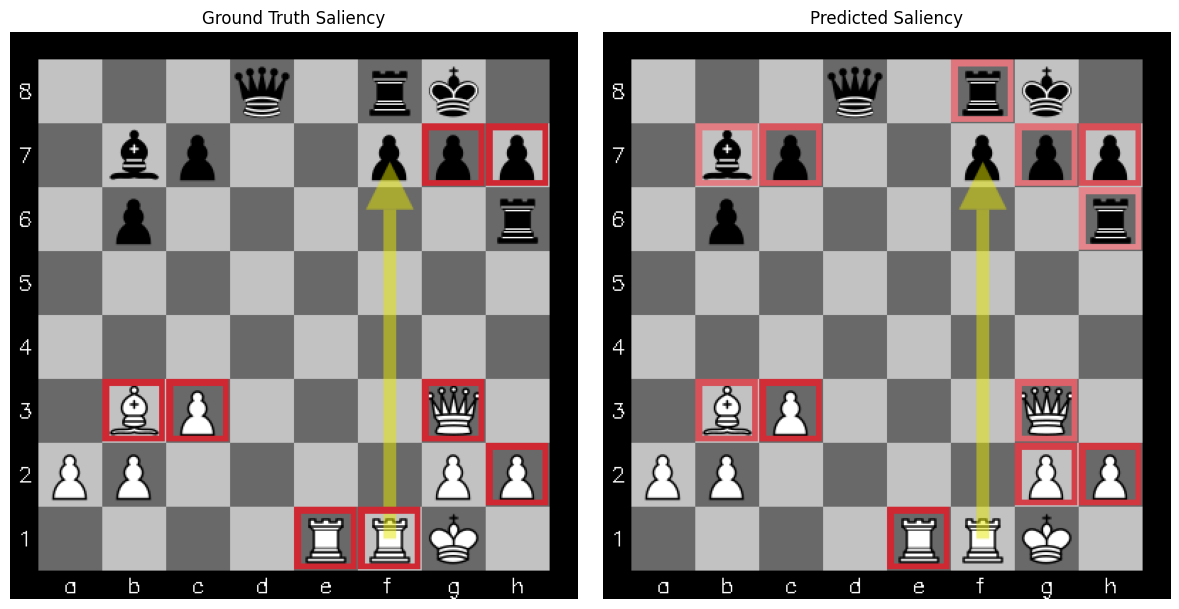

In [49]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, ground_truth_boards[0][0], predicted_saliency, chess.Move.from_uci(optimal_move))

### Compare When Taking the Same Actions

The goal is to see if the same saliency visualizations pop up when we force Stockfish to take the same actions as the experts

In [41]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
ground_truth_moves = ["Rxf7","Rxf7", "Qxc7"]
ground_truth_saliency = {k: 1 for k in ["f1","h2","c3","e1","b3","h7","g3","g7"]}

In [42]:
engine = Engine("./stockfish_15_x64_avx2")

def sequential_saliency_algorithm_forced_moves(fen, discount_factor, depth, forced_moves, runtime=2.0):
    saliency_results_per_step = []
    moves_taken = []
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0
        saliency_results_timestep = defaultdict(int)

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
            saliency_results_timestep[perturbed_position_original_str] += sarfa_compute_result.saliency
        if not optimal_move:
            print("no vaid move found")
            break
        saliency_results_per_step.append((saliency_results_timestep.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        move_uci = board.push_san(forced_moves[curr_step])
        moves_taken.append(move_uci)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results, saliency_results_per_step, moves_taken

In [67]:
predicted_saliency_forced_moves, predicted_saliency_timestamps, predicted_moves = sequential_saliency_algorithm_forced_moves(FEN, DISCOUNT_FACTOR, DEPTH, ground_truth_moves)


curr step: 0
curr step: 1
curr step: 2


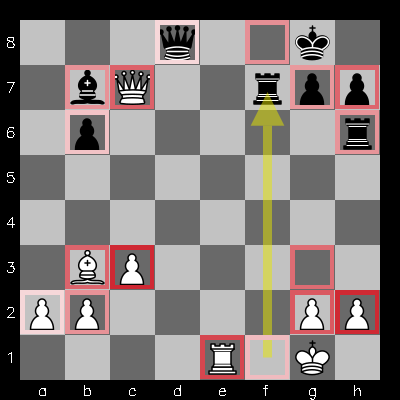

In [43]:
board_visualizer = BoardVisualization(board.copy())

path = board_visualizer.show_heatmap(predicted_saliency, predicted_moves[0])
display(Image(path))

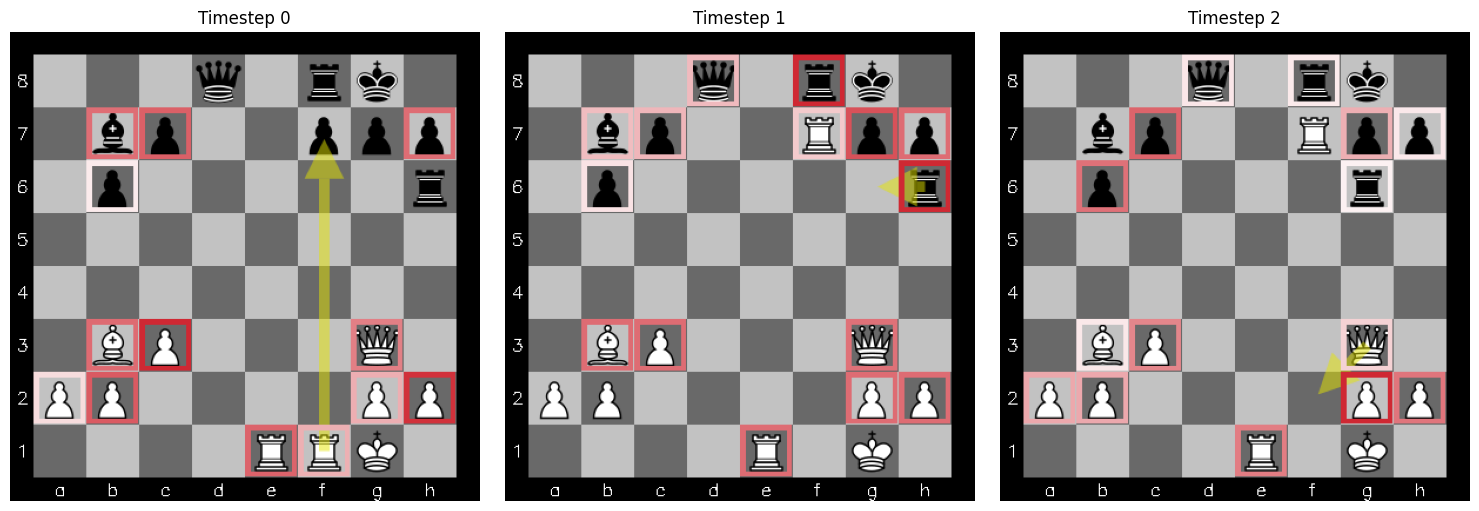

In [44]:
progression_visualizer = ProgressionVisualizer(predicted_saliency_timestamps, predicted_moves)
fig = progression_visualizer.show()
fig.show()

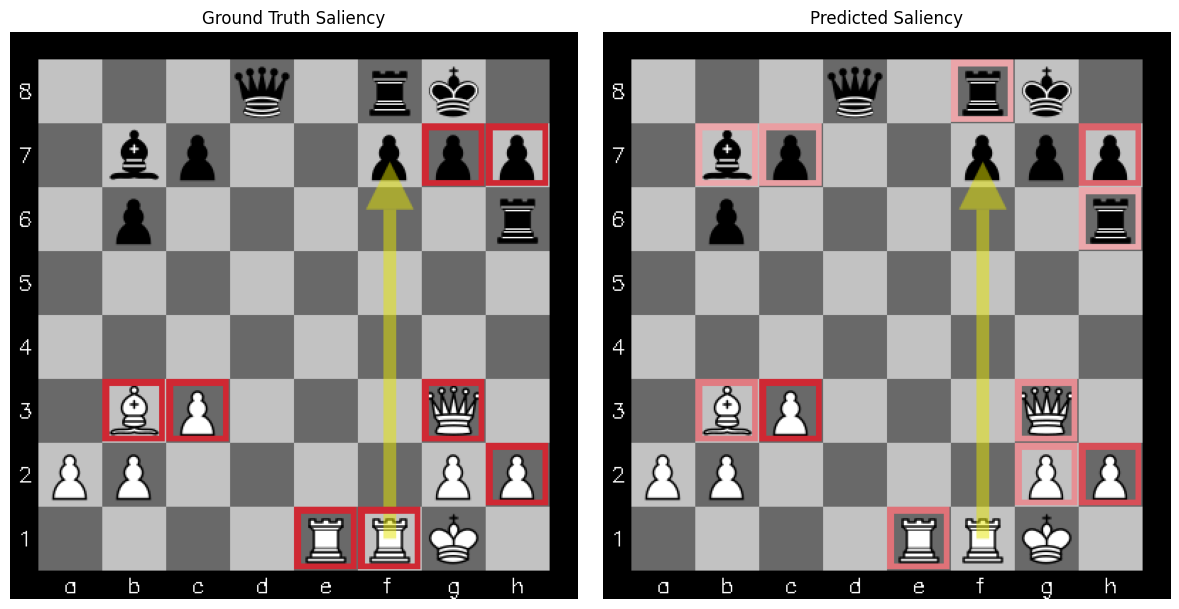

In [63]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, ground_truth_saliency, predicted_saliency, chess.Move.from_uci(optimal_move))

### Final Board Comparisons

Generate image from report of al lthe permutations of different action choices and how the saliency maps are different

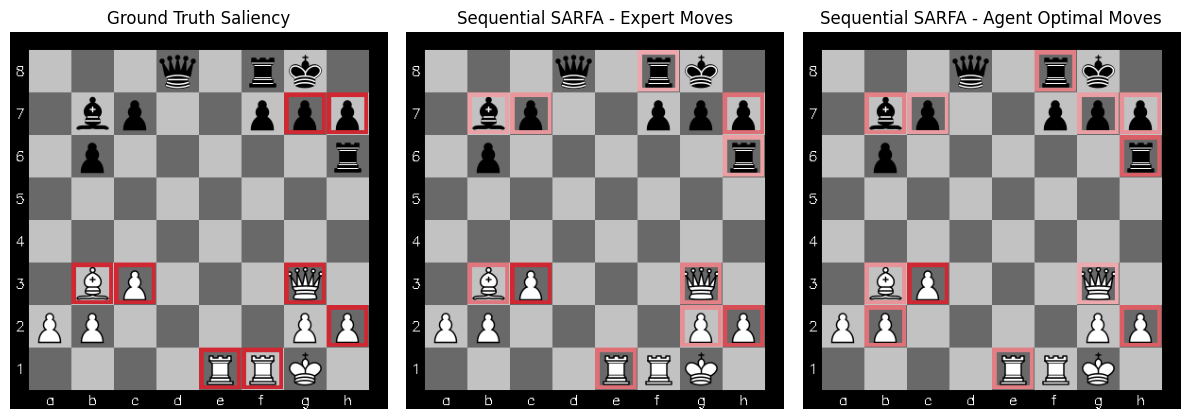

In [74]:
board = chess.Board(FEN)
possible_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(board, possible_moves, len(possible_moves), runtime=2.0)

show_saliency_comparison(FEN, 
    [ground_truth_saliency, predicted_saliency_forced_moves, predicted_saliency], 
    ["Ground Truth Saliency", "Sequential SARFA - Expert Moves", "Sequential SARFA - Agent Optimal Moves"],
    None)

## qualitiative analyis

We want to show an example of a thing that might be hard to understand initially can be explained by sarfa. This is a queen's sacrifice

### End Game

In [16]:
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board, runtime=RUNTIME)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency_result = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency_result.saliency

    return saliency_results


In [17]:
FEN = "6k1/1rr2p2/8/8/4P3/2B2R2/3R1PPP/7K w - - 0 1"
board = chess.Board(FEN)
board_visualizer = BoardVisualization(board.copy())

DEPTH=5

predicted_saliency, predicted_saliency_timestamps, predicted_moves = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH)


curr step: 0
curr step: 1
curr step: 2
curr step: 3
curr step: 4
game finished early


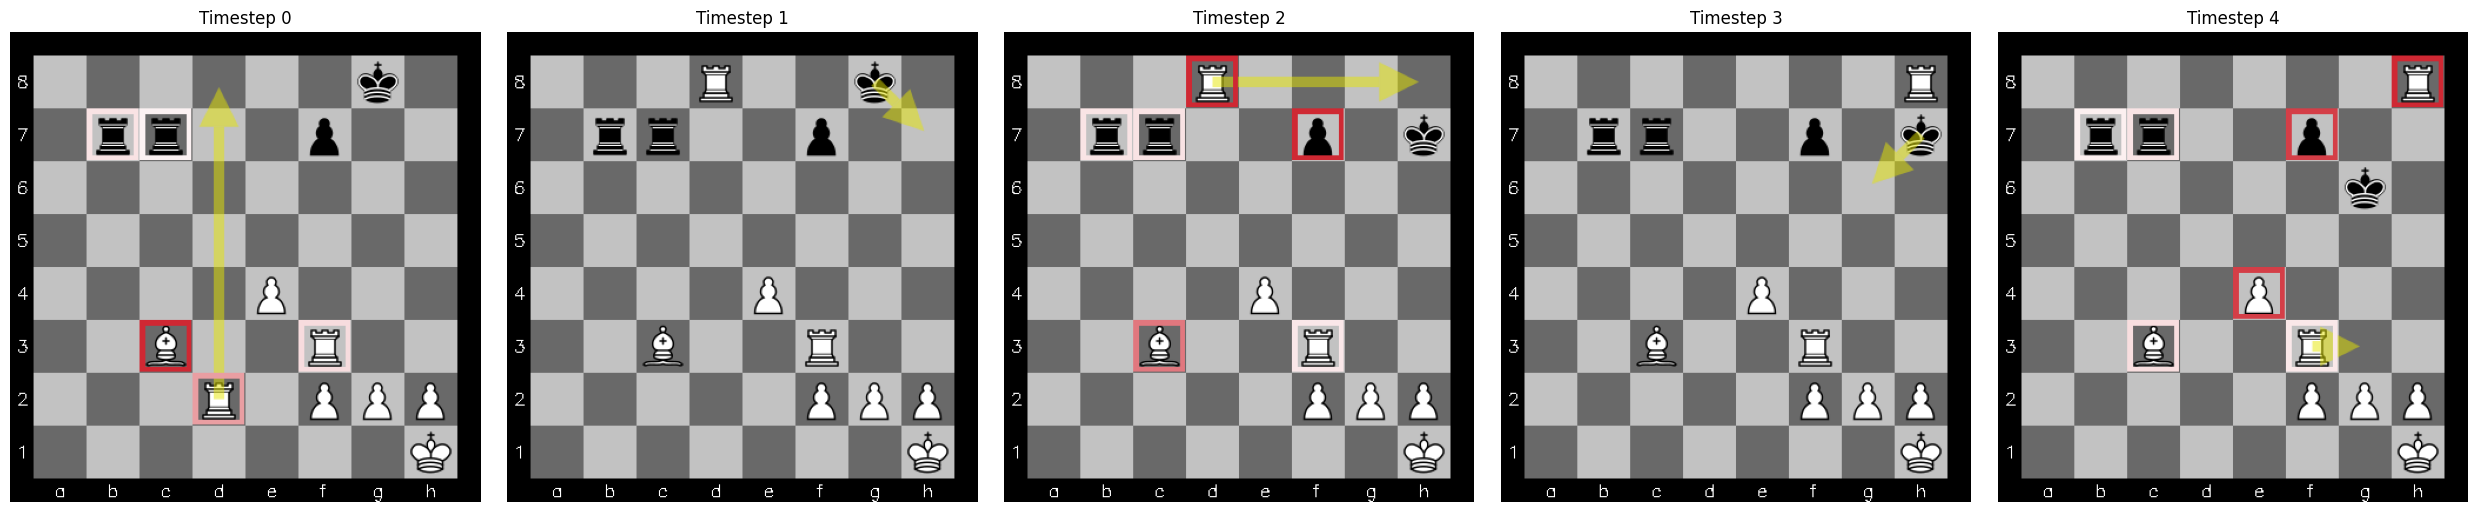

In [18]:
progression_visualizer = ProgressionVisualizer(predicted_saliency_timestamps, predicted_moves)
fig = progression_visualizer.show()
fig.show()

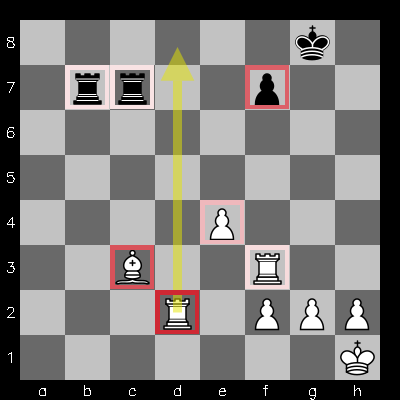

In [19]:
path = board_visualizer.show_heatmap(predicted_saliency, predicted_moves[0])
display(Image(path))

In [20]:
sarfa_saliency = saliency_algorithm(FEN)

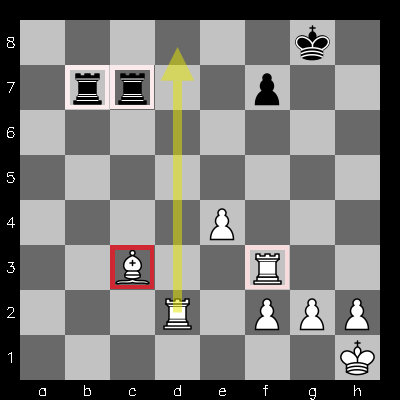

In [21]:
path = board_visualizer.show_heatmap(sarfa_saliency, predicted_moves[0])
display(Image(path))

# Depth Ablation Study

See how the depth of running Sequential SARFA impacts performance

In [73]:
from chess_dataset import SarfaBenchmark

In [74]:
baseline = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_baseline_20")
benchmark_1 = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_1")
benchmark_2 = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_2")
benchmark_3 = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_3")


In [75]:
benchmark_1.accuracy()

{'accuracy - harmonic_mean': 0.7498936343639343}

In [76]:
benchmark_2.accuracy()

{'accuracy - harmonic_mean': 0.7074338592998988}

In [77]:
benchmark_3.accuracy()

{'accuracy - harmonic_mean': 0.7143901852504448}

In [78]:
# roc curve for different depths
fpr_0, tpr_0 = baseline.roc_curve()
fpr_1, tpr_1 = benchmark_1.roc_curve()
fpr_2, tpr_2 = benchmark_2.roc_curve()
fpr_3, tpr_3 = benchmark_3.roc_curve()

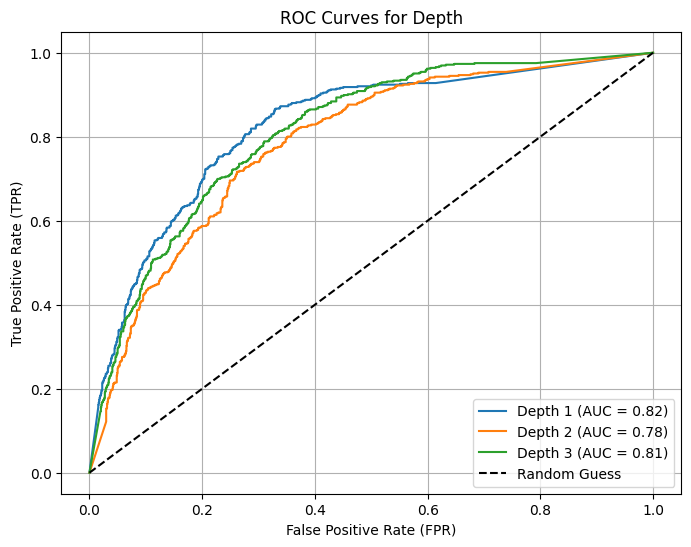

In [79]:
import matplotlib.pyplot as plt

# Example data: Replace these with your actual FPRs and TPRs
roc_data = [
    {"fpr": fpr_1, "tpr": tpr_1, "label": "Depth 1"},
    {"fpr": fpr_2, "tpr": tpr_2, "label": "Depth 2"},
    {"fpr": fpr_3, "tpr": tpr_3, "label": "Depth 3"}
]

# Plotting
plt.figure(figsize=(8, 6))
for roc in roc_data:
    roc_auc = auc(roc["fpr"], roc["tpr"])
    plt.plot(roc["fpr"], roc["tpr"], label=f"{roc['label']} (AUC = {roc_auc:.2f})")

# Adding diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Customization
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Depth')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Runtime abalation study

View the impact of longer time to calculate Q value and whether it changes Sequential SARFA Performance.

In [80]:
baseline = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_baseline_20")
benchmark_1_sec = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_10_90_3")
benchmark_2_sec = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_20_90_3")
benchmark_3_sec = SarfaBenchmark.load_results(sequential_benchmark_function, "sarfa_sequential_30_90_3")

In [81]:
# roc curve for different depths
fpr_0, tpr_0 = baseline.roc_curve()
fpr_1, tpr_1 = benchmark_1_sec.roc_curve()
fpr_2, tpr_2 = benchmark_2_sec.roc_curve()
fpr_3, tpr_3 = benchmark_3_sec.roc_curve()

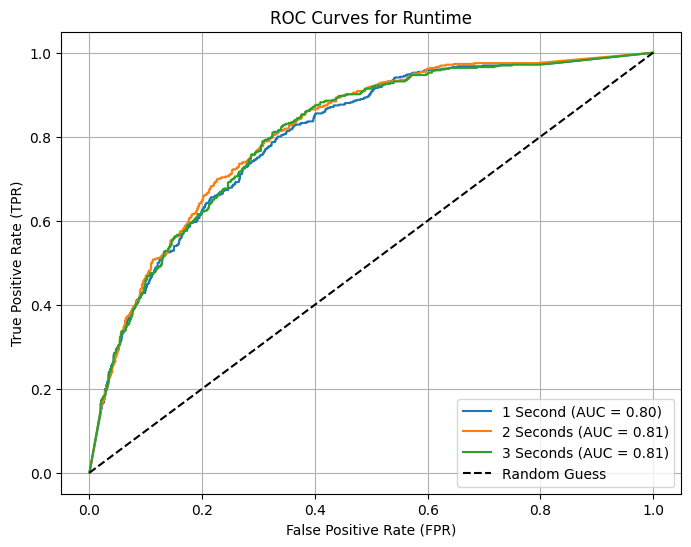

In [82]:
import matplotlib.pyplot as plt

# Example data: Replace these with your actual FPRs and TPRs
roc_data = [
    {"fpr": fpr_1, "tpr": tpr_1, "label": "1 Second"},
    {"fpr": fpr_2, "tpr": tpr_2, "label": "2 Seconds"},
    {"fpr": fpr_3, "tpr": tpr_3, "label": "3 Seconds"}
]

# Plotting
plt.figure(figsize=(8, 6))
for roc in roc_data:
    roc_auc = auc(roc["fpr"], roc["tpr"])
    plt.plot(roc["fpr"], roc["tpr"], label=f"{roc['label']} (AUC = {roc_auc:.2f})")

# Adding diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Customization
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Runtime')
plt.legend(loc='lower right')
plt.grid()
plt.show()
